# Wind Turbine Power Prediction

In this study We are going to predict a wind turbine power production by using the wind speed, wind direction, month and hour data.

The dataset consists of 50530 observations. In order to demonstrate data science skills with big data, We am going to use Pyspark library.

The dataset contains:

* Date/Time (for 10 minutes intervals)
* LV ActivePower (kW): The power generated by the turbine for that moment
* Wind Speed (m/s): The wind speed at the hub height of the turbine (the wind speed that turbine use for electricity generation)
* TheoreticalPowerCurve (KWh): The theoretical power values that the turbine generates with that wind speed which is given by the turbine manufacturer
* Wind Direction (deg): The wind direction at the hub height of the turbine (wind turbines turn to this direction automaticly)

Dataset Resource: 

https://www.kaggle.com/berkerisen/wind-turbine-scada-dataset

## Aim of the Study:

<b>To predict wind turbine power production from the wind speed, wind direction, month of the year and the hour of the day.</b>

## Copy T1.csv to DataTab

In [4]:
%%local
!hadoop fs -mkdir dtap://TenantStorage/Scada-Dataset
!hadoop fs -copyFromLocal dataset/T1.csv dtap://TenantStorage/Scada-Dataset

mkdir: `dtap://TenantStorage/Scada-Dataset': File exists
copyFromLocal: `dtap://TenantStorage/Scada-Dataset/T1.csv': File exists


In [ ]:
%%configure -f 
{
     "conf": {
            "spark.ssl.enabled": false,
            "spark.hadoop.fs.dtap.impl": "com.bluedata.hadoop.bdfs.Bdfs",
            "spark.hadoop.fs.AbstractFileSystem.dtap.impl": "com.bluedata.hadoop.bdfs.BdAbstractFS",
            "spark.hadoop.fs.dtap.impl.disable.cache": "false",
            "spark.driver.extraClassPath": "local:///opt/bdfs/bluedata-dtap.jar",
            "spark.executor.extraClassPath": "local:///opt/bdfs/bluedata-dtap.jar",
            "spark.kubernetes.driver.label.hpecp.hpe.com/dtap": "hadoop2",
            "spark.kubernetes.executor.label.hpecp.hpe.com/dtap": "hadoop2"
        }
}

Starting Spark application


## Importing Libraries and Spark Configuration

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
from warnings import filterwarnings
filterwarnings('ignore')

# Importing pyspark libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark import SparkContext

Starting Spark application


## Reading the Dataset

In [4]:
spark_df = spark.read.csv('dtap://TenantStorage/Scada-Dataset/T1.csv', header=True, inferSchema=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
# Caching the dataset
spark_df.cache()

# Converting all the column names to lower case
spark_df = spark_df.toDF(*[c.lower() for c in spark_df.columns])

print('Show the first 5 rows')
print(spark_df.show(5))
print()
print('What are the variable data types?')
print(spark_df.printSchema())
print()
print('How many observations do we have?')
print(spark_df.count())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Show the first 5 rows
+----------------+-------------------+----------------+-----------------------------+--------------------+
|       date/time|lv activepower (kw)|wind speed (m/s)|theoretical_power_curve (kwh)|wind direction (deg)|
+----------------+-------------------+----------------+-----------------------------+--------------------+
|01 01 2018 00:00|        380.0477905|      5.31133604|                  416.3289078|         259.9949036|
|01 01 2018 00:10|        453.7691956|     5.672166824|                  519.9175111|         268.6411133|
|01 01 2018 00:20|        306.3765869|     5.216036797|                  390.9000158|         272.5647888|
|01 01 2018 00:30|        419.6459045|     5.659674168|                   516.127569|         271.2580872|
|01 01 2018 00:40|        380.6506958|     5.577940941|                   491.702972|         265.6742859|
+----------------+-------------------+----------------+-----------------------------+--------------------+
only showing to

In [6]:
# Extracting a substring from columns to create month and hour variables

from pyspark.sql.functions import substring
spark_df = spark_df.withColumn("month", substring("date/time", 4,2))
spark_df = spark_df.withColumn("hour", substring("date/time", 12,2))

# Converting string month and hour variables to integer
from pyspark.sql.types import IntegerType
spark_df = spark_df.withColumn('month', spark_df.month.cast(IntegerType()))
spark_df = spark_df.withColumn('hour', spark_df.hour.cast(IntegerType()))

print(spark_df.show(5))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+-------------------+----------------+-----------------------------+--------------------+-----+----+
|       date/time|lv activepower (kw)|wind speed (m/s)|theoretical_power_curve (kwh)|wind direction (deg)|month|hour|
+----------------+-------------------+----------------+-----------------------------+--------------------+-----+----+
|01 01 2018 00:00|        380.0477905|      5.31133604|                  416.3289078|         259.9949036|    1|   0|
|01 01 2018 00:10|        453.7691956|     5.672166824|                  519.9175111|         268.6411133|    1|   0|
|01 01 2018 00:20|        306.3765869|     5.216036797|                  390.9000158|         272.5647888|    1|   0|
|01 01 2018 00:30|        419.6459045|     5.659674168|                   516.127569|         271.2580872|    1|   0|
|01 01 2018 00:40|        380.6506958|     5.577940941|                   491.702972|         265.6742859|    1|   0|
+----------------+-------------------+----------------+-

## Exploratory Data Analysis

In [7]:
pd.options.display.float_format = '{:.2f}'.format
spark_df.select('wind speed (m/s)', 'theoretical_power_curve (kwh)', 'lv activepower (kw)').toPandas().describe()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

       wind speed (m/s)  theoretical_power_curve (kwh)  lv activepower (kw)
count          50530.00                       50530.00             50530.00
mean               7.56                        1492.18              1307.68
std                4.23                        1368.02              1312.46
min                0.00                           0.00                -2.47
25%                4.20                         161.33                50.68
50%                7.10                        1063.78               825.84
75%               10.30                        2964.97              2482.51
max               25.21                        3600.00              3618.73

### Question: What are the distributions of the variables?

**For creating visualization we need to either use aggregated data or use a sample from the big data.**

**So we will get a random sample from our input.**

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

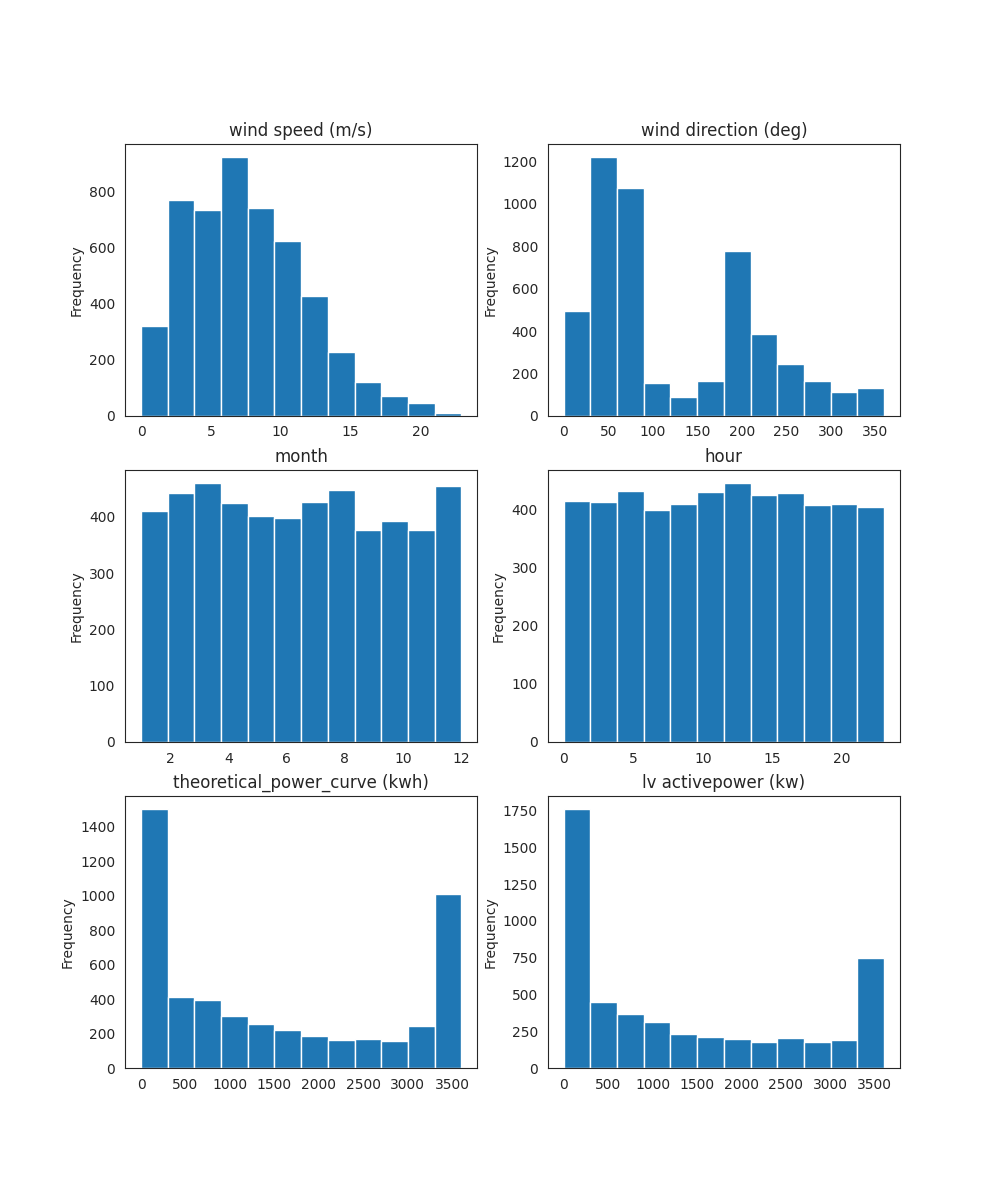

In [8]:
# Taking a random sample from the big data
sample_df = spark_df.sample(withReplacement=False, fraction=0.1, seed=42).toPandas()

# Visualizing the distributions with the sample data
columns = ['wind speed (m/s)', 'wind direction (deg)', 'month', 'hour', 'theoretical_power_curve (kwh)', 'lv activepower (kw)']
i=1
plt.figure(figsize=(10,12))
for each in columns:
    plt.subplot(3,2,i)
    sample_df[each].plot.hist(bins=12)
    plt.title(each)
    i += 1
%matplot plt

### Question: Is there any difference between the months for average power production ?

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

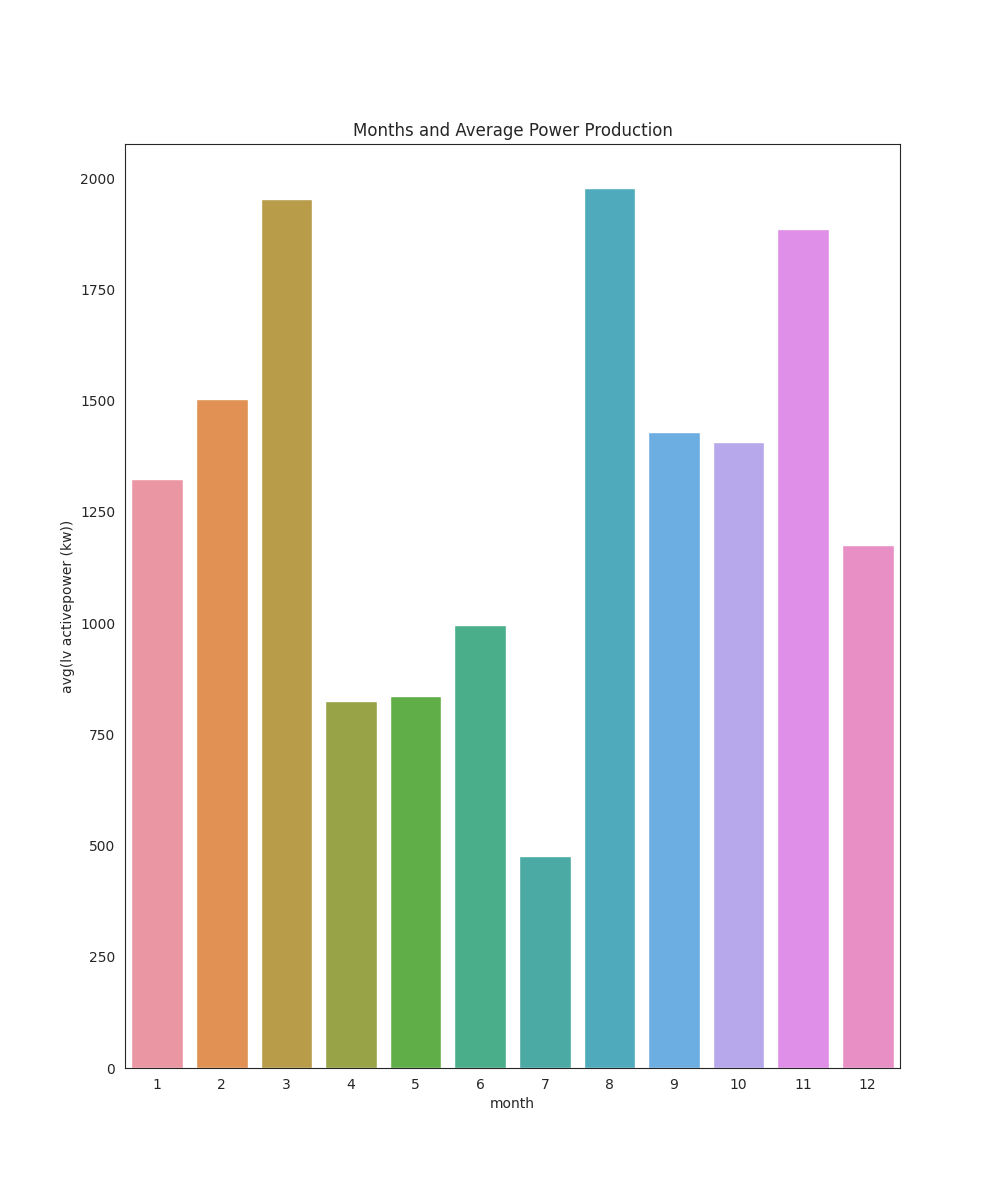

In [9]:
plt.clf()

# Average power production by month
monthly = spark_df.groupby('month').mean('lv activepower (kw)').sort('avg(lv activepower (kw))').toPandas()
sns.barplot(x='month', y='avg(lv activepower (kw))', data=monthly)
plt.title('Months and Average Power Production');

%matplot plt

### Question: Is there any difference between the hours for average power production?

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

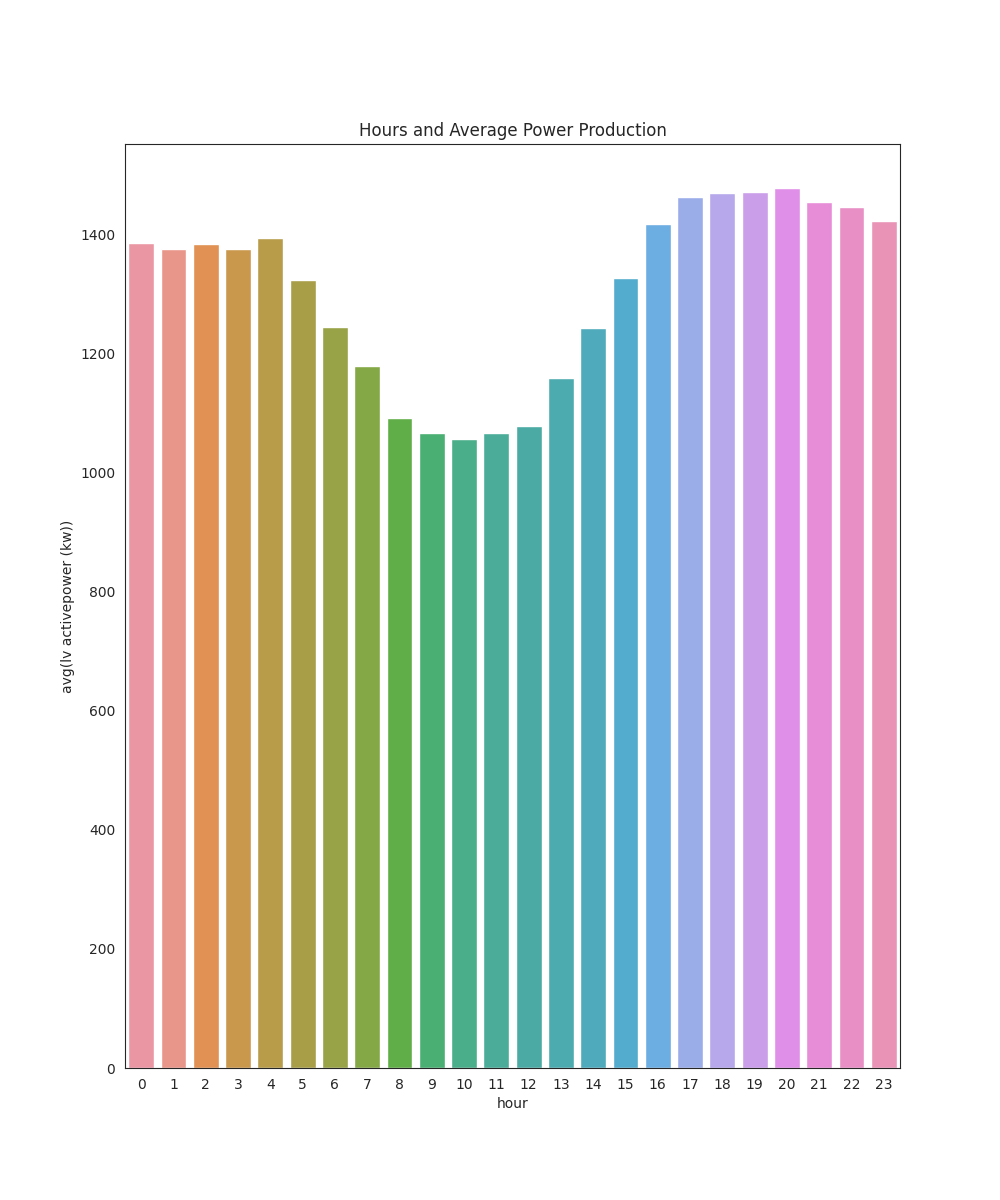

In [10]:
plt.clf()

# Average power production by hour
hourly = spark_df.groupby('hour').mean('lv activepower (kw)').sort('avg(lv activepower (kw))').toPandas()
sns.barplot(x='hour', y='avg(lv activepower (kw))', data=hourly)
plt.title('Hours and Average Power Production');

%matplot plt

### Question: Is there any correlation between the wind speed, wind direction and power production?

In [11]:
pd.set_option('display.max_columns', None)
sample_df[columns].corr()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                               wind speed (m/s)  wind direction (deg)  month  \
wind speed (m/s)                           1.00                 -0.08  -0.01   
wind direction (deg)                      -0.08                  1.00  -0.18   
month                                     -0.01                 -0.18   1.00   
hour                                       0.03                  0.00  -0.01   
theoretical_power_curve (kwh)              0.95                 -0.11  -0.00   
lv activepower (kw)                        0.91                 -0.06   0.04   

                               hour  theoretical_power_curve (kwh)  \
wind speed (m/s)               0.03                           0.95   
wind direction (deg)           0.00                          -0.11   
month                         -0.01                          -0.00   
hour                           1.00                           0.03   
theoretical_power_curve (kwh)  0.03                           1.00   
lv activepower (kw)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

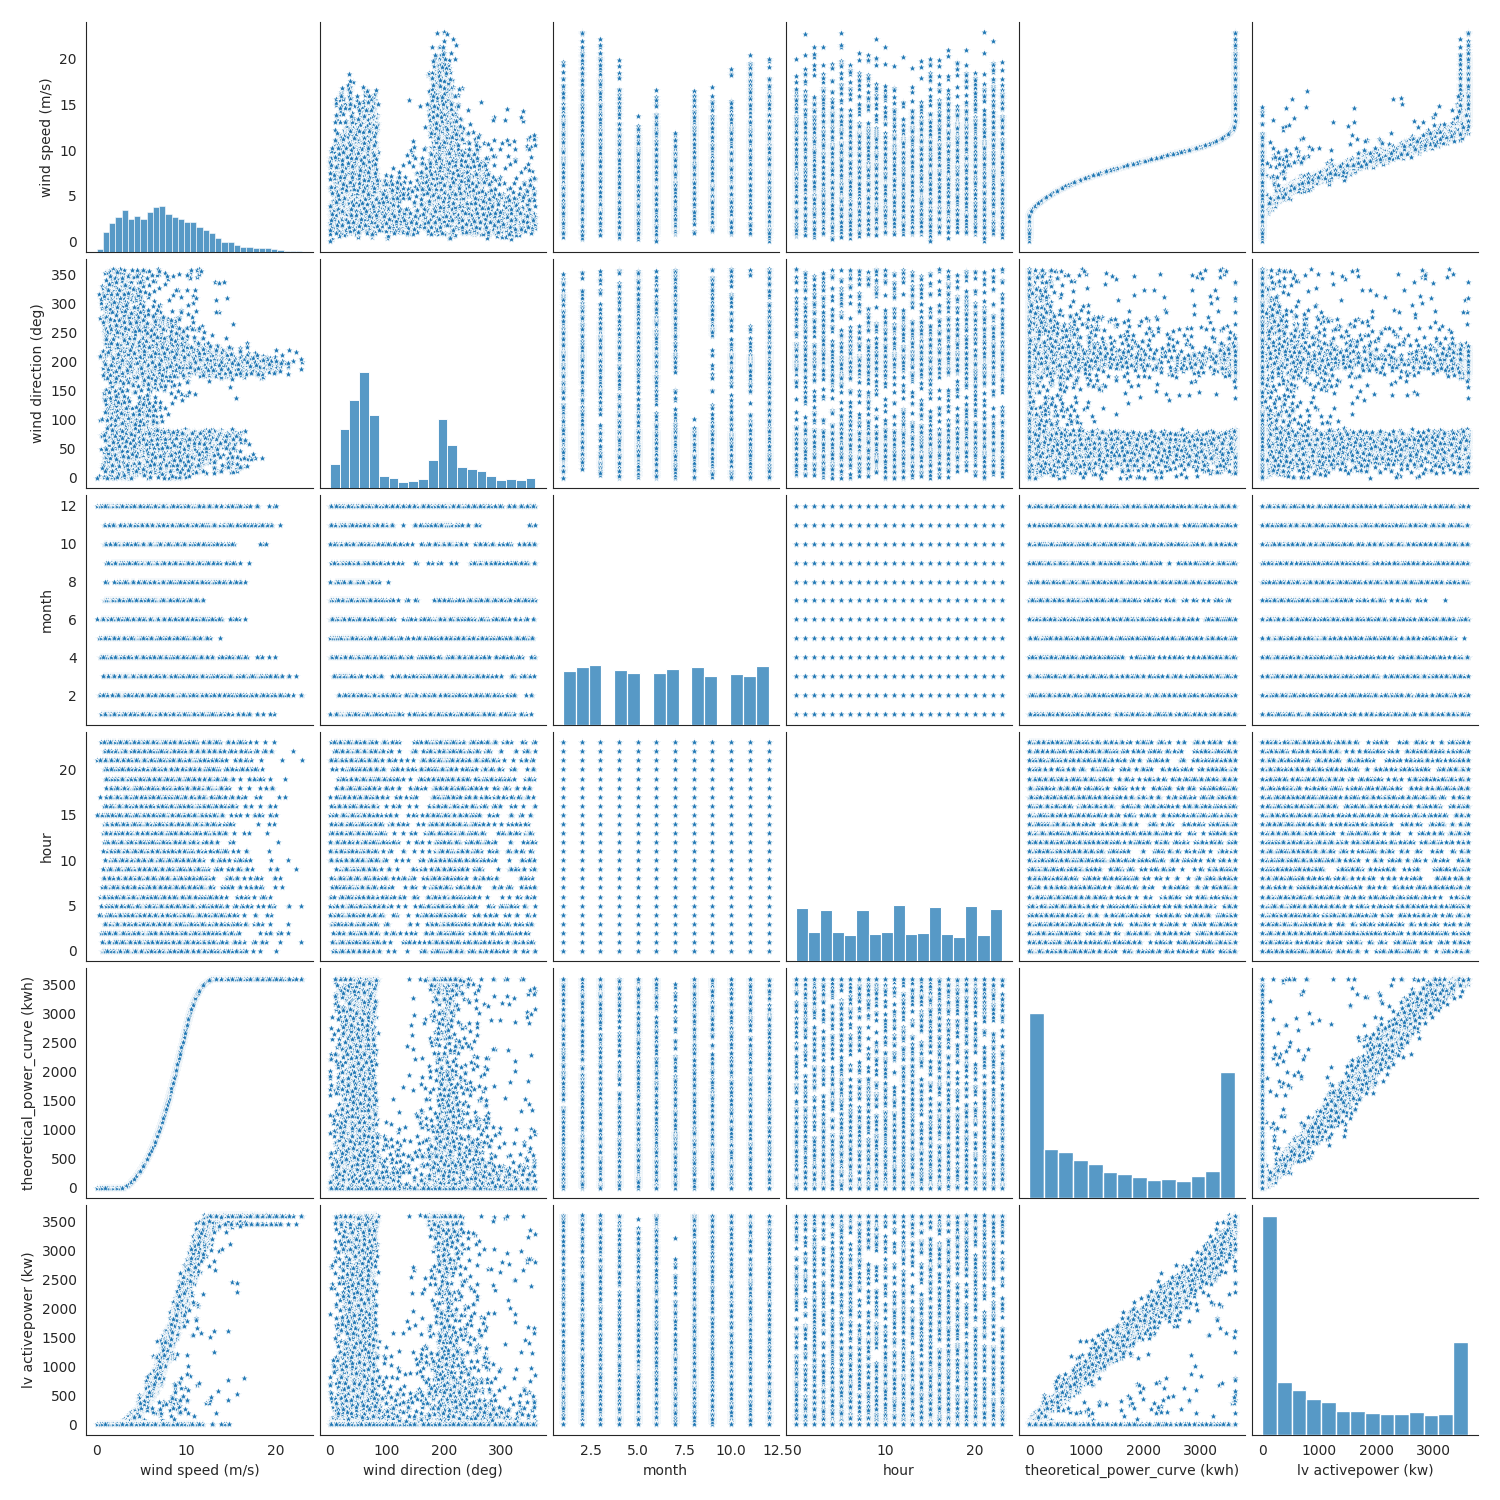

In [12]:
plt.clf()
sns.pairplot(sample_df[columns], markers='*');
%matplot plt

**Wind speed and power production is highly correlated as one would expect.**

**We can see there are lower level power production for some wind directions.**

### Question: What is the average power production level for different wind speeds?

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

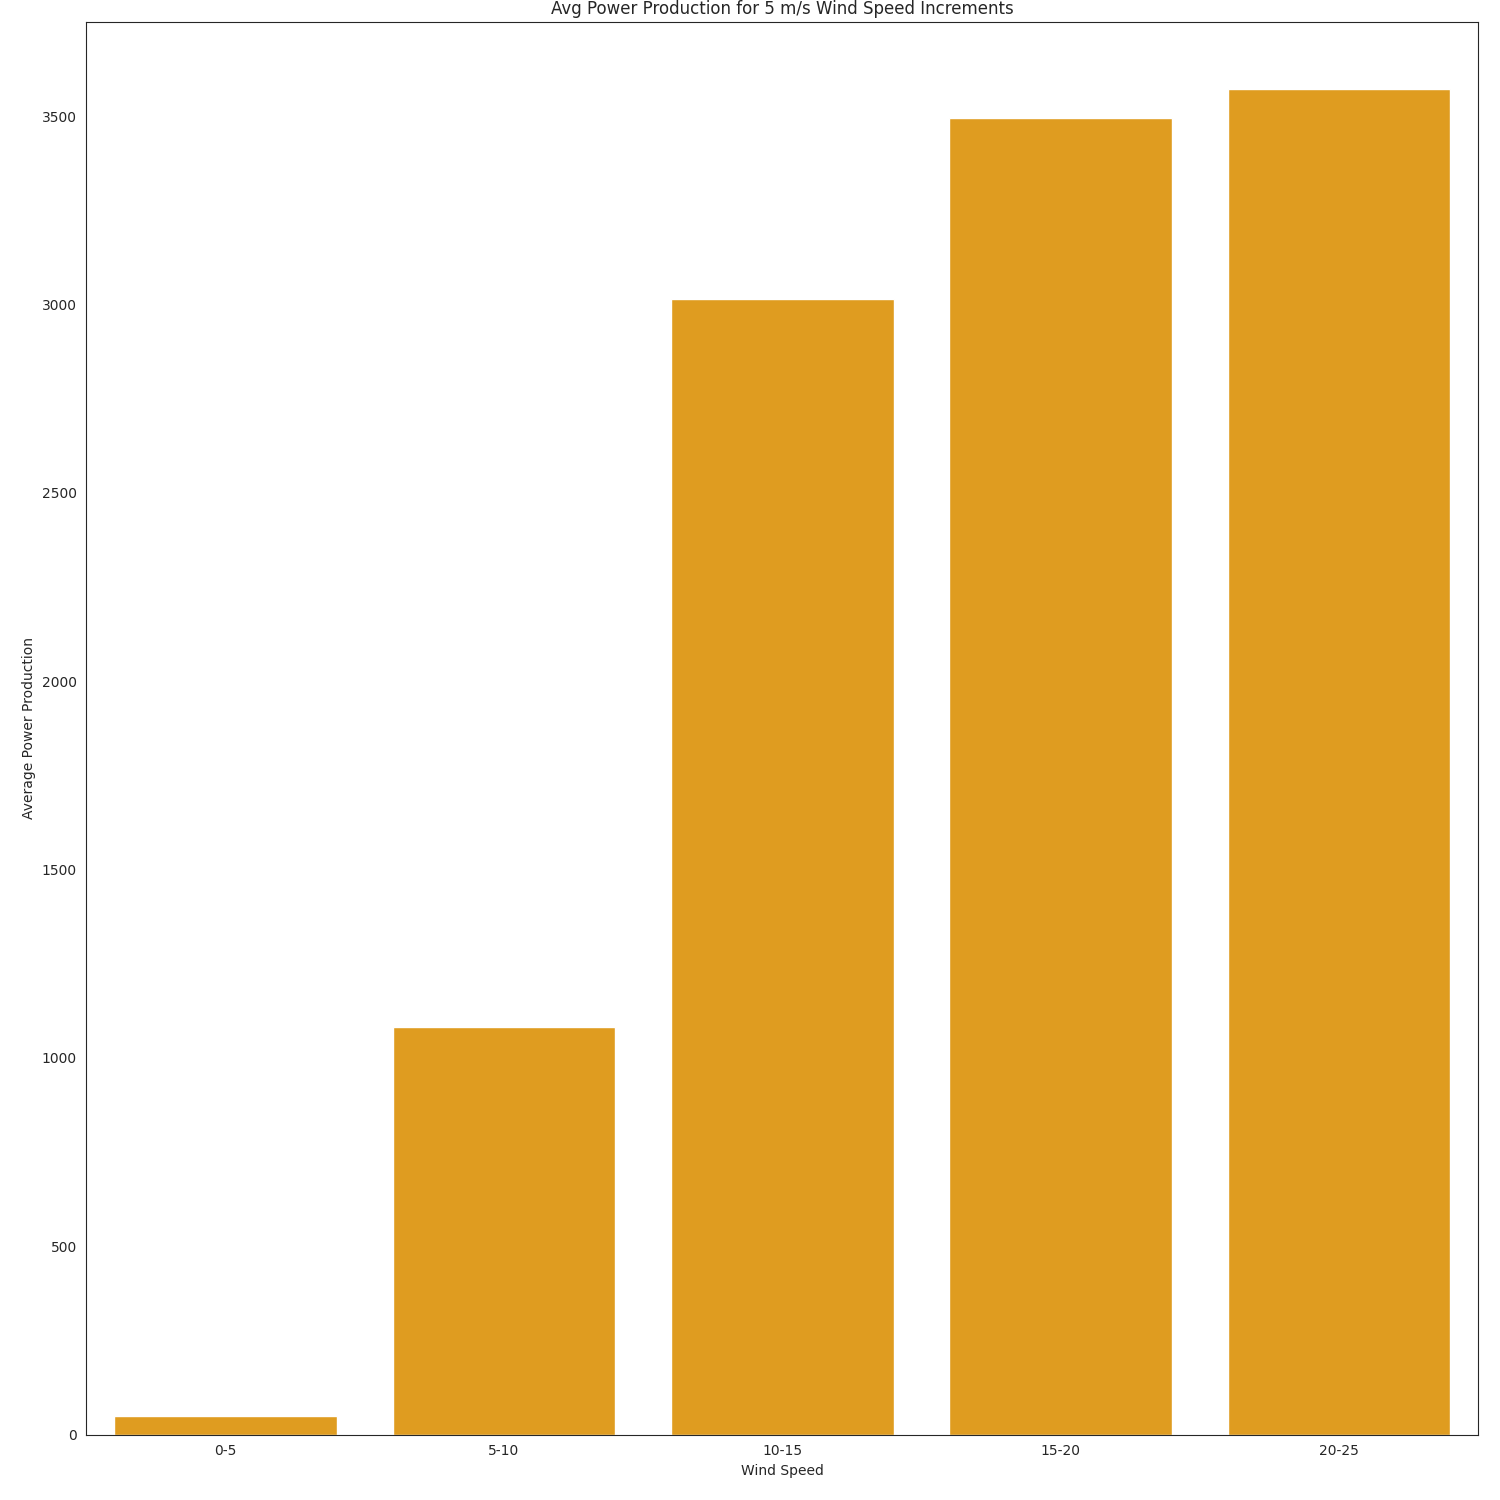

In [13]:
# Finding average power production for 5 m/s wind speed increments
wind_speed = []
avg_power = []
for i in [0,5,10,15,20]:
    avg_value = spark_df.filter((spark_df['wind speed (m/s)'] > i) 
                                & (spark_df['wind speed (m/s)'] <= i+5))\
                                .agg({'lv activepower (kw)':'mean'}).collect()[0][0] 
    avg_power.append(avg_value)
    wind_speed.append(str(i) + '-' + str(i+5))

plt.clf()
sns.barplot(x=wind_speed, y=avg_power, color='orange')
plt.title('Avg Power Production for 5 m/s Wind Speed Increments')
plt.xlabel('Wind Speed')
plt.ylabel('Average Power Production');

%matplot plt

**From the graph above we can see the power production reaches near a maximum level after the wind speed reaches 15 m/s.**

### Question: What is the power production for different wind directions and speeds? 

**Let's create a polar diagram with wind speed, wind direction and power production from the sample data.**

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

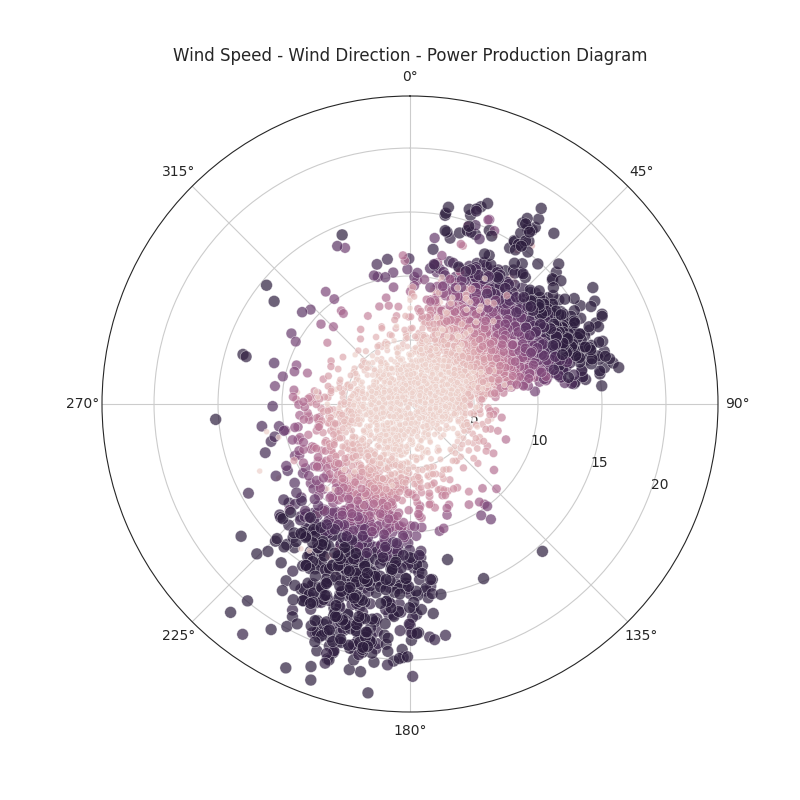

In [14]:
# Creating the polar diagram
from math import radians

plt.clf()
plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)
# Inside circles are the wind speed and marker color and size represents the amount of power production
sns.scatterplot(x=[radians(x) for x in sample_df['wind direction (deg)']], 
                y=sample_df['wind speed (m/s)'],
                size=sample_df['lv activepower (kw)'],
                hue=sample_df['lv activepower (kw)'],
                alpha=0.7, legend=None)
# Setting the polar diagram's top represents the North 
ax.set_theta_zero_location('N')
# Setting -1 to start the wind direction clockwise
ax.set_theta_direction(-1)
# Setting wind speed labels in a better position to see
ax.set_rlabel_position(110)
plt.title('Wind Speed - Wind Direction - Power Production Diagram')
plt.ylabel(None);

%matplot plt

**We can see that the wind turbine produces more power if the wind blows from the directions between 0-90 and 180-225 degrees.**

### Question: Does the manufacturer's theoritical power production curve fit well with the real production?

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

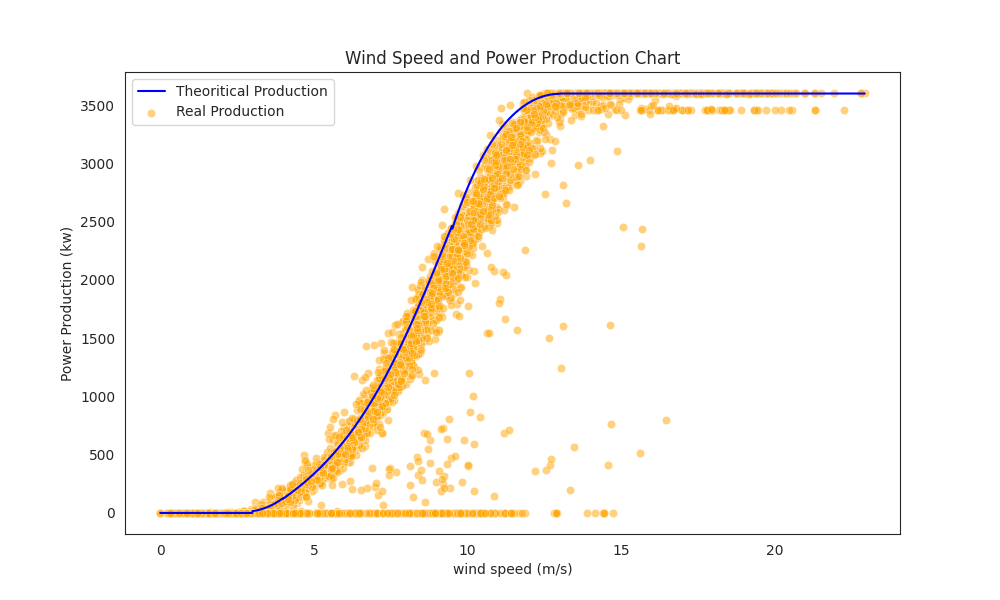

In [15]:
plt.clf()
plt.figure(figsize=(10,6))
sns.scatterplot(x='wind speed (m/s)', y='lv activepower (kw)', color='orange', label='Real Production', alpha=0.5, data=sample_df)
sns.lineplot(x='wind speed (m/s)', y='theoretical_power_curve (kwh)', color='blue', label='Theoritical Production', data=sample_df)
plt.title('Wind Speed and Power Production Chart')
plt.ylabel('Power Production (kw)');

%matplot plt

**From the graph above, we can see the theoritical power production curve generally fits well with the real production.**

**We can see the power production reaches a maximum level and continues in a straight line if the wind speed reaches to 15 m/s.**

**Also we can see there are some 0 power production, even the wind speed is higher than 5 m/s. Lets investigate the reason.**

**But before that what is the minimum wind speed for theoritical power production curve?**

### Question: What is the wind speed threshold value for zero theorical power?

In [16]:
# Filter the big data where the real and theoritical power productions are equal to 0
zero_theo_power = spark_df.filter((spark_df['lv activepower (kw)'] == 0)
                                  & (spark_df['theoretical_power_curve (kwh)'] == 0)).toPandas()

print(zero_theo_power[['wind speed (m/s)', 'theoretical_power_curve (kwh)', 'lv activepower (kw)']].sample(5))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

      wind speed (m/s)  theoretical_power_curve (kwh)  lv activepower (kw)
5853              2.55                           0.00                 0.00
1085              0.38                           0.00                 0.00
6814              1.80                           0.00                 0.00
2455              2.95                           0.00                 0.00
1984              0.59                           0.00                 0.00

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

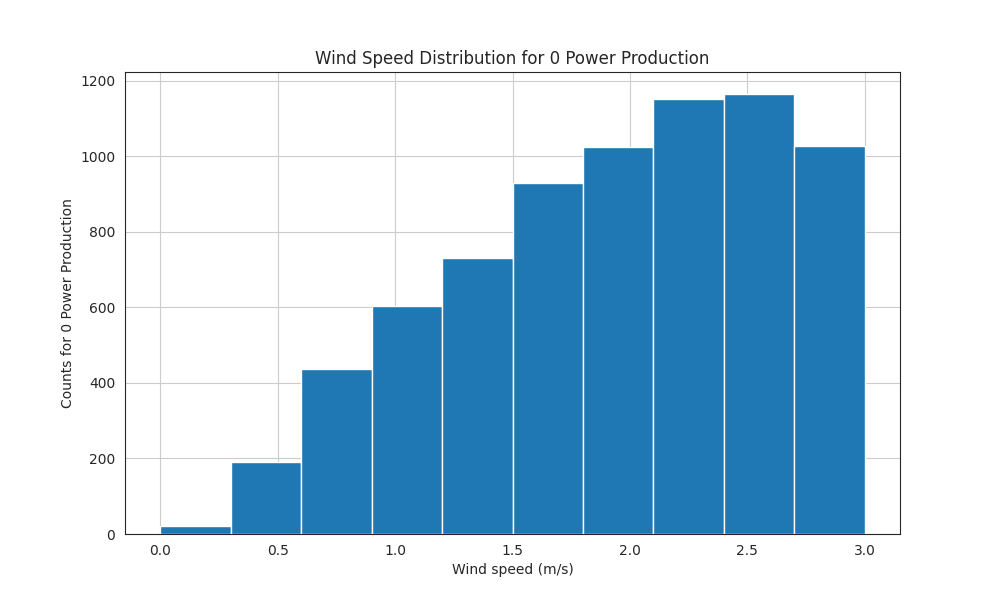

In [17]:
plt.clf()
# Let's see the wind speed distribution for 0 power production
zero_theo_power['wind speed (m/s)'].hist()
plt.title('Wind Speed Distribution for 0 Power Production')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Counts for 0 Power Production');

%matplot plt

**We can see from above, limit for the theoritical power curve is 3 m/s wind speed. If the wind speed is below 3 m/s model doesn't expect any power production.**

**But there are some observations for 0 power production even the wind speed is more than 3 m/s.**

### Question: Why there aren't any power production in some observations while the wind speed is higher than 3 m/s?

In [18]:
# Observations for the wind speed > 3m/s and power production = 0, 
# While theoritically there should be power production
zero_power = spark_df.filter((spark_df['lv activepower (kw)'] == 0)
                            & (spark_df['theoretical_power_curve (kwh)'] != 0)
                            & (spark_df['wind speed (m/s)'] > 3)).toPandas()
print(zero_power.head())
print('No of Observations (while Wind Speed > 3 m/s and Power Production = 0): ', len(zero_power))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

          date/time  lv activepower (kw)  wind speed (m/s)  \
0  03 01 2018 15:40                 0.00              3.74   
1  03 01 2018 16:40                 0.00              3.03   
2  03 01 2018 16:50                 0.00              3.20   
3  03 01 2018 17:00                 0.00              3.91   
4  04 01 2018 13:50                 0.00              3.44   

   theoretical_power_curve (kwh)  wind direction (deg)  month  hour  
0                          83.99                245.07      1    15  
1                          17.18                221.09      1    16  
2                          25.43                232.68      1    16  
3                         110.98                241.97      1    17  
4                          45.74                 79.09      1    13  
No of Observations (while Wind Speed > 3 m/s and Power Production = 0):  3497

**There are 3497 observations where theoritically there should be power production. From the dataset we cannot see the reason, it might be caused by maintenance. But let's see if we can see any information from the wind speed, direction and month?**

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

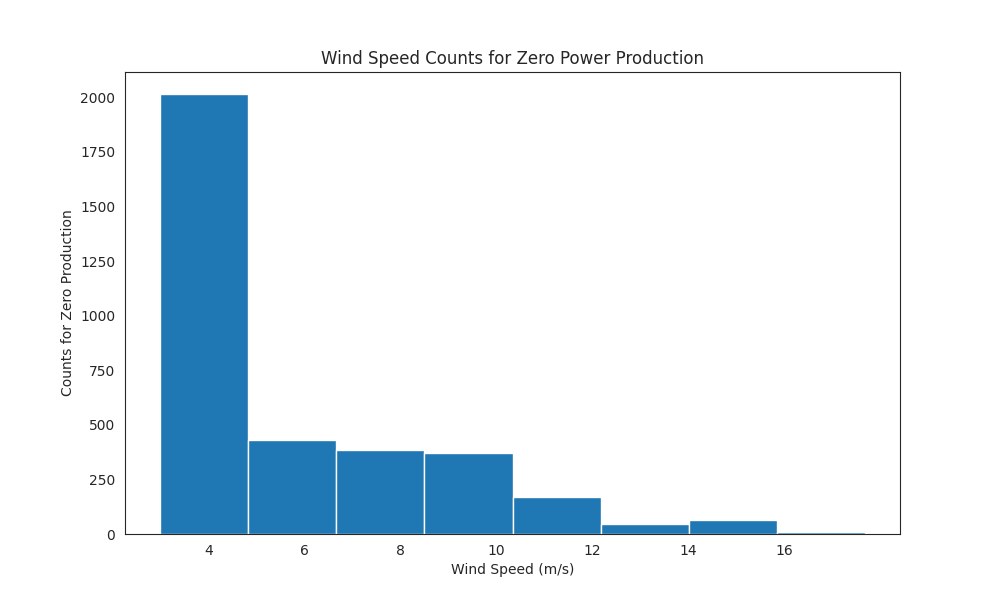

In [19]:
plt.clf()
zero_power['wind speed (m/s)'].plot.hist(bins=8)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Counts for Zero Production')
plt.title('Wind Speed Counts for Zero Power Production')
plt.xticks(ticks=np.arange(4,18,2));

%matplot plt

**It looks like theoritically wind speed threshold should be 4 m/s. But there are also other observations with zero power production while the wind speed is higher.**

**Let's see the monthly distribution for zero power production.**

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

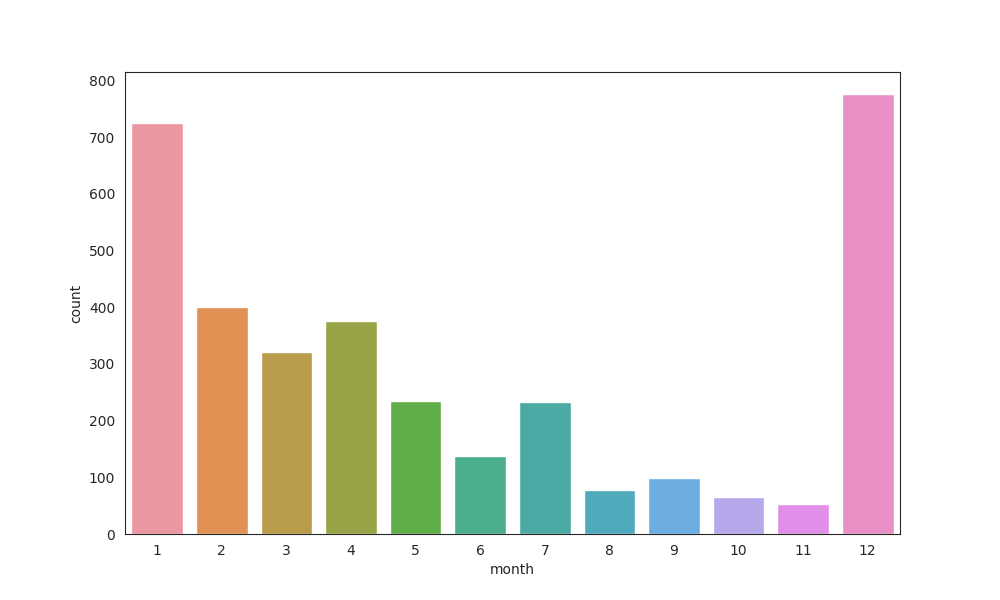

In [20]:
plt.clf()
sns.countplot(zero_power['month']);
%matplot plt

**It is usually in December and January when the wind turbine doesn't produce production.**

**Because on the available information we cannot decide if these zero power productions are caused by maintenance periods or something else, Lets assume those 3497 observations as outliers and remove them from the dataset.**

In [21]:
# Excluding the observations meeting the filter criterias 
spark_df = spark_df.filter(~((spark_df['lv activepower (kw)'] == 0)
                            & (spark_df['theoretical_power_curve (kwh)'] != 0)
                            & (spark_df['wind speed (m/s)'] > 3)))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
spark_df.show(20)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+-------------------+----------------+-----------------------------+--------------------+-----+----+
|       date/time|lv activepower (kw)|wind speed (m/s)|theoretical_power_curve (kwh)|wind direction (deg)|month|hour|
+----------------+-------------------+----------------+-----------------------------+--------------------+-----+----+
|01 01 2018 00:00|        380.0477905|      5.31133604|                  416.3289078|         259.9949036|    1|   0|
|01 01 2018 00:10|        453.7691956|     5.672166824|                  519.9175111|         268.6411133|    1|   0|
|01 01 2018 00:20|        306.3765869|     5.216036797|                  390.9000158|         272.5647888|    1|   0|
|01 01 2018 00:30|        419.6459045|     5.659674168|                   516.127569|         271.2580872|    1|   0|
|01 01 2018 00:40|        380.6506958|     5.577940941|                   491.702972|         265.6742859|    1|   0|
|01 01 2018 00:50|        402.3919983|     5.604052067| 

### Question: Is there any other outliers?

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

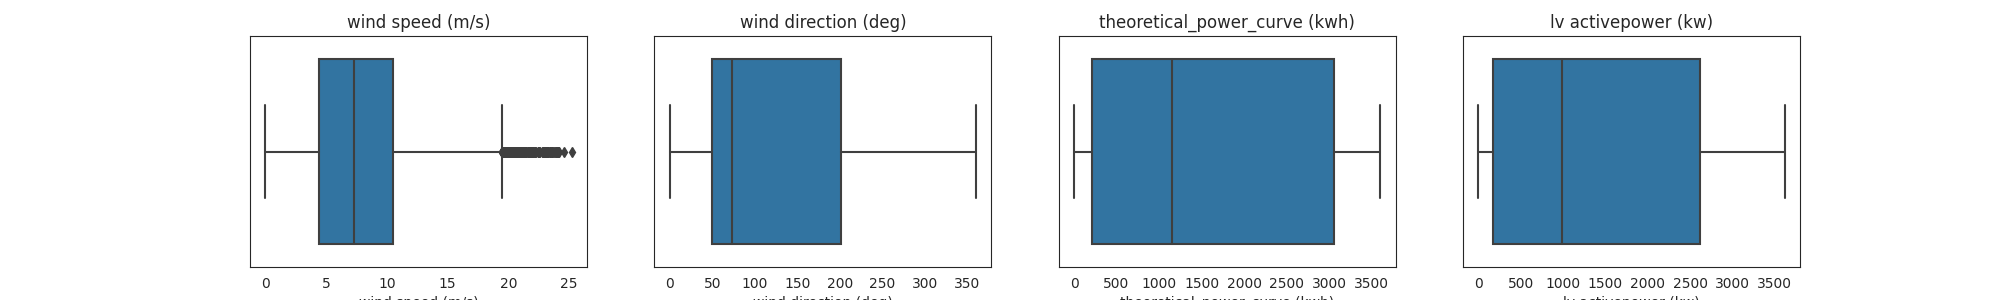

In [23]:
columns = ['wind speed (m/s)', 'wind direction (deg)', 'theoretical_power_curve (kwh)', 'lv activepower (kw)']
i=1
plt.clf()
plt.figure(figsize=(20,3))
for each in columns:
    df = spark_df.select(each).toPandas()
    plt.subplot(1,4,i)
    #plt.boxplot(df)
    sns.boxplot(x=df[each])
    plt.title(each)
    i += 1
    
%matplot plt

**From the graphs above we can see there are some outliers in the wind speed data.**

**We will find the upper and lower threshold values for the wind speed data, and analyze the outliers.**

In [24]:
# Create a pandas df for visualization
wind_speed = spark_df.select('wind speed (m/s)').toPandas()

# Defining the quantiles and interquantile range
Q1 = wind_speed['wind speed (m/s)'].quantile(0.25)
Q3 = wind_speed['wind speed (m/s)'].quantile(0.75)
IQR = Q3-Q1
# Defining the lower and upper threshold values
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

print('Quantile (0.25): ', Q1, '  Quantile (0.75): ', Q3)
print('Lower threshold: ', lower, ' Upper threshold: ', upper)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Quantile (0.25):  4.455846786   Quantile (0.75):  10.47719002
Lower threshold:  -4.576168064999999  Upper threshold:  19.509204871

In [25]:
# Fancy indexing for outliers
outlier_tf = (wind_speed['wind speed (m/s)'] < lower) | (wind_speed['wind speed (m/s)'] > upper)

print('Total Number of Outliers: ', len(wind_speed['wind speed (m/s)'][outlier_tf]))
print('--'*15)
print('Some Examples of Outliers:')
print(wind_speed['wind speed (m/s)'][outlier_tf].sample(10))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Number of Outliers:  407
------------------------------
Some Examples of Outliers:
9260    20.97
3274    19.61
3514    22.94
10916   19.90
3548    21.81
3609    19.53
3255    20.78
6956    20.92
3556    23.23
3577    20.64
Name: wind speed (m/s), dtype: float64

**It is a rare event for wind speed to be over 19 m/s in our dataset.**

**Out of 47033, there is only 407 observations while the wind speed is over 19 m/s.**

**Now Lets see average power production for these high wind speed.**

In [26]:
spark_df.select('wind speed (m/s)', 'lv activepower (kw)')\
.filter(spark_df['wind speed (m/s)'] >= 19)\
.agg({'lv activepower (kw)':'mean'}).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------------+
|avg(lv activepower (kw))|
+------------------------+
|      3566.4634427902906|
+------------------------+

**So instead of erasing the outliers, we are going to set the wind speed as 19 m/s for those observations.**

In [27]:
from pyspark.sql import functions as F
spark_df = spark_df.withColumn('wind speed (m/s)', 
                               F.when(F.col('wind speed (m/s)') > 19.447, 19)
                               .otherwise(F.col('wind speed (m/s)')))
spark_df.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

47033

### Question: What are the general criterias for power production?

**It is important to understand the pattern in the data. We should learn the data before the machine.**

**1. We saw from the graph that in March, August and November, the average power production is higher.**

**2. The average power production is higher daily between 16:00 and 24:00.**

**3. The power production is higher when the wind blows from the directions between 0-90 and 180-225 degrees.**

**So let's try to predict a high and low level of power production from the criterias above before ML algorithm.**

In [28]:
# High level power production
spark_df.filter(((spark_df['month'] == 3) | (spark_df['month'] == 8) | (spark_df['month'] == 11)) 
                & ((spark_df['hour'] >= 16) | (spark_df['hour'] <= 24)) 
                & ((spark_df['wind direction (deg)'] > 0) | (spark_df['wind direction (deg)'] < 90))
                & ((spark_df['wind direction (deg)'] > 180) | (spark_df['wind direction (deg)'] < 225))
               ).agg({'lv activepower (kw)':'mean'}).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------------+
|avg(lv activepower (kw))|
+------------------------+
|      2013.4446757911744|
+------------------------+

In [29]:
# Low level power production
spark_df.filter((spark_df['month'] == 7) 
                & ((spark_df['hour'] >= 9) | (spark_df['hour'] <= 11)) 
                & ((spark_df['wind direction (deg)'] > 90) | (spark_df['wind direction (deg)'] < 160))
               ).agg({'lv activepower (kw)':'mean'}).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------------+
|avg(lv activepower (kw))|
+------------------------+
|      503.16442054071854|
+------------------------+

## Data Preparation for ML Algorithms

**After analysing and understanding the dataset, we can build a ML regression model to predict wind turbine power production by using the wind speed, wind direction, month of the year and hour of the day.**

**Using ML algorithms with Spark is a bit different from well known Sckitlearn library.**

**We need to feed the model with a dataframe made of variables compressed in vectors called as 'features', and target variable as 'label'. For these convertions we are going to use VectorAssembler method from Pyspark.**

In [30]:
# Preparing the independent variables (Features)
from pyspark.ml.feature import VectorAssembler

# Converting lv activepower (kw) variable as label
spark_df = spark_df.withColumn('label', spark_df['lv activepower (kw)'])

# Defining the variables to be used
variables = ['month', 'hour', 'wind speed (m/s)', 'wind direction (deg)']
vectorAssembler = VectorAssembler(inputCols = variables, outputCol = 'features')
va_df = vectorAssembler.transform(spark_df)

# Combining features and label column
final_df = va_df.select('features', 'label')
final_df.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----------+
|            features|      label|
+--------------------+-----------+
|[1.0,0.0,5.311336...|380.0477905|
|[1.0,0.0,5.672166...|453.7691956|
|[1.0,0.0,5.216036...|306.3765869|
|[1.0,0.0,5.659674...|419.6459045|
|[1.0,0.0,5.577940...|380.6506958|
|[1.0,0.0,5.604052...|402.3919983|
|[1.0,1.0,5.793007...|447.6057129|
|[1.0,1.0,5.306049...|387.2421875|
|[1.0,1.0,5.584629...|463.6512146|
|[1.0,1.0,5.523228...| 439.725708|
+--------------------+-----------+
only showing top 10 rows

## Train Test Split

**Now we can split our dataset into train and test datasets.**

In [31]:
splits = final_df.randomSplit([0.8, 0.2])
train_df = splits[0]
test_df = splits[1]

print('Train dataset: ', train_df.count())
print('Test dataset : ', test_df.count())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Train dataset:  37636
Test dataset :  9397

## Creating the Initial Model

**Lets use GBT regressor for this study.**

In [32]:
from pyspark.ml.regression import GBTRegressor

# Creating the gbm regressor object
gbm = GBTRegressor(featuresCol='features', labelCol='label')

# Training the model with train data
gbm_model = gbm.fit(train_df)

# Predicting using the test data
y_pred = gbm_model.transform(test_df)

# Initial look at the target and predicted values
y_pred.select('label', 'prediction').show(20)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+------------------+
|      label|        prediction|
+-----------+------------------+
|        0.0|10.078485676408896|
|        0.0| 7.739168826710808|
|296.4699097| 309.1983096096114|
|314.6347961|308.35761569233773|
|359.0282898| 309.1983096096114|
|380.0477905|413.34822538333736|
|368.4970093|413.34822538333736|
|402.3919983|413.34822538333736|
|576.8709717| 636.6819517411064|
|875.7213135| 777.0892619192302|
|949.4943237| 848.0885690619721|
| 1045.36499| 879.4524607933693|
|1085.182007|1174.0622488563397|
|1340.303955|1367.9541689937826|
|1724.671997|1725.2649975934796|
|1840.800049| 1741.312692932289|
| 893.031311|1410.9115141741909|
| 2292.50293|  2105.00410867714|
|1009.817017|1410.9115141741909|
|2446.424072|2248.0774550585975|
+-----------+------------------+
only showing top 20 rows

**Store our model in dtap**

In [33]:
gbm_model.write().overwrite().save('dtap://TenantStorage/Scada-Model/GBM.model')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

**Load Model - Test**

In [34]:
from pyspark.ml.regression import GBTRegressionModel
gbm_model_dtap = GBTRegressionModel.load("dtap://TenantStorage/Scada-Model/GBM.model")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

**Let's evaluate our model's success.**

In [35]:
# Initial model success
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='label')

print('R2 SCORE : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'r2'}))
print('MAE      : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'mae'}))
print('RMSE     : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'rmse'}))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

R2 SCORE :  0.9787475289623574
MAE      :  85.56992586036401
RMSE     :  190.3463486264077

**R2 score means, real power production's 98% variability can be explained by the ML model.**

**MAE is the mean absolute difference between the real and predicted power production.**

**RMSE is the square root of mean squared difference between the real and predicted values.**

**Even though the R2 is high, we should also check the MAE and RMSE values with the real value's summary statistics.**

**One can tune the hyperparameters to increase the model success.**

## Comparing Real, Theoritical and Predicted Power Productions

**Lets use sample_df for comparing the actual, theoritical and the model power productions.**

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

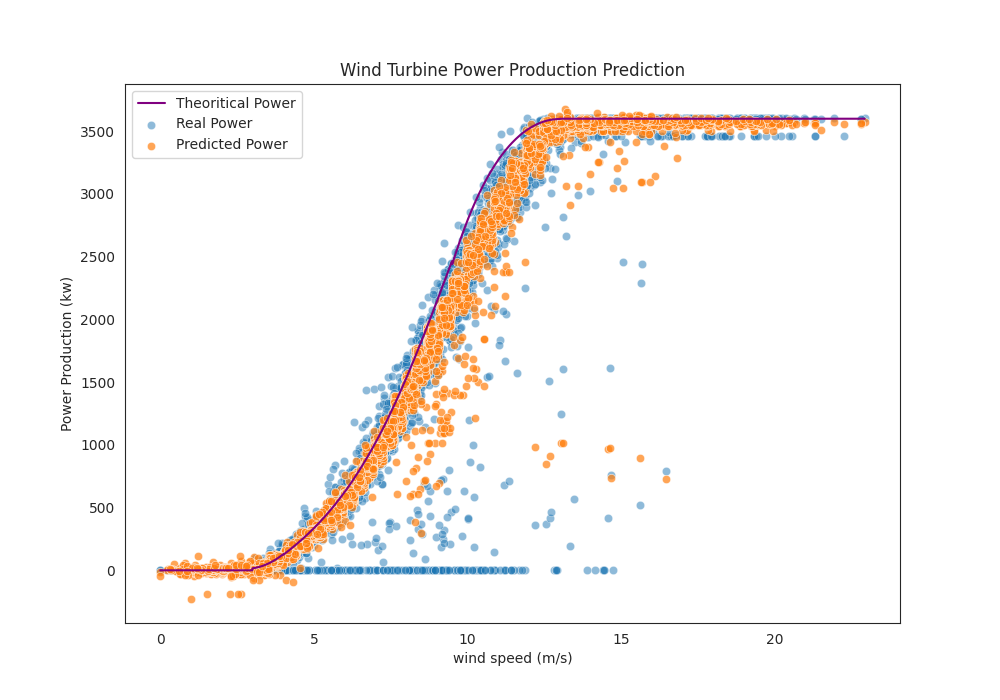

In [36]:
# Converting sample_df back to Spark dataframe
eva_df = spark.createDataFrame(sample_df)

# Converting lv activepower (kw) variable as label
eva_df = eva_df.withColumn('label', eva_df['lv activepower (kw)'])

# Defining the variables to be used
variables = ['month', 'hour', 'wind speed (m/s)', 'wind direction (deg)']
vectorAssembler = VectorAssembler(inputCols = variables, outputCol = 'features')
vec_df = vectorAssembler.transform(eva_df)

# Combining features and label column
vec_df = vec_df.select('features', 'label')

# Using ML model to predict
preds = gbm_model.transform(vec_df)
preds_df = preds.select('label','prediction').toPandas()

# Compining dataframes to compare
frames = [sample_df[['wind speed (m/s)', 'theoretical_power_curve (kwh)']], preds_df]
sample_data = pd.concat(frames, axis=1)

plt.clf()
# Visualizing real, theoritical and predicted power production
plt.figure(figsize=(10,7))
sns.scatterplot(x='wind speed (m/s)', y='label',alpha=0.5, label= 'Real Power', data=sample_data)
sns.scatterplot(x='wind speed (m/s)', y='prediction', alpha=0.7, label='Predicted Power', marker='o', data=sample_data)
sns.lineplot(x='wind speed (m/s)', y='theoretical_power_curve (kwh)', label='Theoritical Power',color='purple', data=sample_data)
plt.title('Wind Turbine Power Production Prediction')
plt.ylabel('Power Production (kw)')
plt.legend();

%matplot plt

**From the graph above, the model fits better to the real power productions, than the theoritical power production curve.**

In [40]:
%%local
!hadoop fs -ls dtap://TenantStorage/Scada-Model/GBM.model

Found 3 items
drwxr-xr-x   - dev1 domain users          0 2022-04-01 07:57 dtap://TenantStorage/Scada-Model/GBM.model/data
drwxr-xr-x   - dev1 domain users          0 2022-04-01 07:57 dtap://TenantStorage/Scada-Model/GBM.model/metadata
drwxr-xr-x   - dev1 domain users          0 2022-04-01 07:57 dtap://TenantStorage/Scada-Model/GBM.model/treesMetadata
